In [1]:
from pathlib import Path
import matplotlib.pyplot as plt


from lightweight_gan import LightweightGAN
import torch
import numpy as np

from PIL import Image
from torchvision.transforms import v2

# For CPU only



In [2]:
MODEL_PATH = Path("model/model_mercury_5_param_9000.pt")
LATENT_DIM = 256
IMG_SIZE = 256

torch.manual_seed(42)

In [3]:
def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow((im_arr*255).astype(np.uint8))


def import_generator(model_filepath: Path) -> torch.nn.Module:
    model = torch.load(model_filepath)
    
    gan = LightweightGAN(latent_dim=LATENT_DIM,
                         image_size=IMG_SIZE, 
                         attn_res_layers=[32],
                         freq_chan_attn=False)
    gan.load_state_dict(model["GAN"], strict=False)
    gan.eval()

    return gan.G

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).cuda(0)


def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((255*images[i]).reshape(images[idx].shape[0], images[idx].shape[1]).astype(np.uint8))
        else:
            ax.imshow((255*images[idx]).astype(np.uint8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_loss(losses, iterations, title=""):
    plt.plot(iterations, losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.ylim(bottom=0, top=1.1*max(losses))
    plt.show()
    
    
def present_results(z, checkpoints, losses, original_image):
    generator = import_generator(MODEL_PATH)
    plot_images([checkpoint for _, checkpoint in checkpoints],
            [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints],
            nrows=len(checkpoints)//4, ncols=4,
            title="Generated images for parameters with value 128", figsize=[8, 6])
    
    original_image
    original_middle_image = prep_tensor_to_show(original_image)
    inffered_middle_image = prep_tensor_to_show(generator(z)[0])
    plot_images([original_middle_image, inffered_middle_image],
            ["original", "inferred"], 
            nrows=1, ncols=2,
            title="Original and inferred image",
            figsize=[8, 4])
    
    plot_loss(losses, checkpoints, title="Losses")

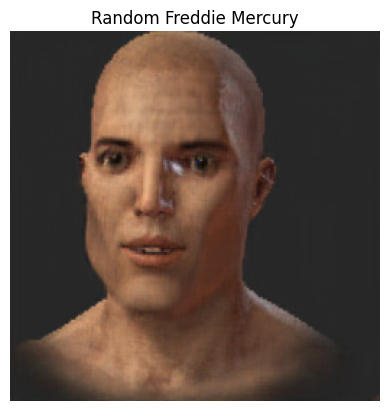

In [4]:
generator = import_generator(MODEL_PATH)

random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
generated_images = generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random Freddie Mercury")

In [5]:
def present_results(original_image, z, checkpoints, losses):
    plot_images([checkpoint for _, checkpoint in checkpoints],
            [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints],
            nrows=len(checkpoints)//4, ncols=4,
            title="Generated images for parameters with value 128", figsize=[8, 6])
    
    original_image = prep_tensor_to_show(original_image)
    inffered_image = prep_tensor_to_show(generator(z)[0])
    plot_images([original_image, inffered_image],
            ["original", "inferred"], 
            nrows=1, ncols=2,
            title="Original and inferred image",
            figsize=[8, 4])
    
    plot_loss(losses, [i for i, _ in checkpoints], title="Loss")
    

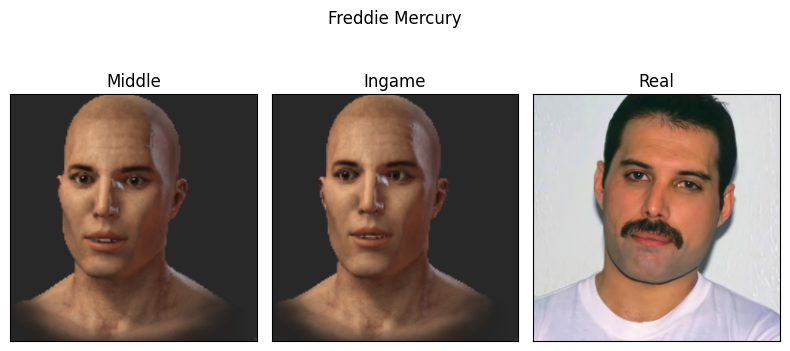

In [6]:
MIDDLE_IMAGE_PATH = "img/from_dataset/middle_mercury.png"
FREDDIE_INGAME_PATH = "img/from_dataset/perfect_mercury.png"
FREDDIE_REAL_PATH = "img/real-freddies/1.jpg"

middle_image = prep_image(MIDDLE_IMAGE_PATH)
freddie_ingame = prep_image(FREDDIE_INGAME_PATH)
freddie_real = prep_image(FREDDIE_REAL_PATH)

plot_images([prep_tensor_to_show(img) for img in (middle_image, freddie_ingame, freddie_real)],
            ["Middle", "Ingame", "Real"],
            1, 3, title="Freddie Mercury")

## MSE

### Middle picture

In [6]:
## MSE

def find_z_MSE(exemplary_photo, iterations=100, lr=5, checkpoint_step=10, z_init=None):
    z = torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda") \
        if z_init is None else z_init
    y_target = exemplary_photo

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([z], lr=lr)

    checkpoints = []
    losses = []
    for i in range(iterations):
        y_pred = generator(z)[0]
        loss = criterion(y_target, y_pred)

        if i % checkpoint_step == 0:
            checkpoints.append((i, y_pred.detach().permute((1,2,0)).cpu().numpy()))
            losses.append(loss.item())
            print(f"Iteration: {i}, loss: {loss.item():.2E}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return z, checkpoints, losses


In [9]:
middle_z, middle_checkpoints, middle_losses = find_z_MSE(middle_image, iterations=1000, lr=1, checkpoint_step=100)

Iteration: 0, loss: 1.14E-03
Iteration: 100, loss: 7.30E-04
Iteration: 200, loss: 6.83E-04
Iteration: 300, loss: 6.32E-04
Iteration: 400, loss: 4.40E-04
Iteration: 500, loss: 4.25E-04
Iteration: 600, loss: 4.15E-04
Iteration: 700, loss: 4.07E-04
Iteration: 800, loss: 4.00E-04
Iteration: 900, loss: 3.92E-04


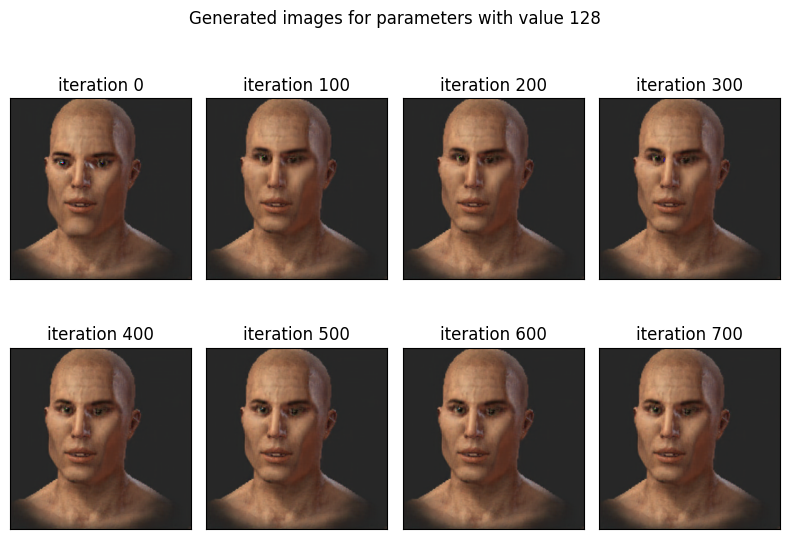

In [10]:
plot_images([checkpoint for _, checkpoint in middle_checkpoints],
            [f"iteration {checkpoint_n}" for checkpoint_n, _ in middle_checkpoints],
            nrows=len(middle_checkpoints)//4, ncols=4,
            title="Generated images for parameters with value 128", figsize=[8, 6])

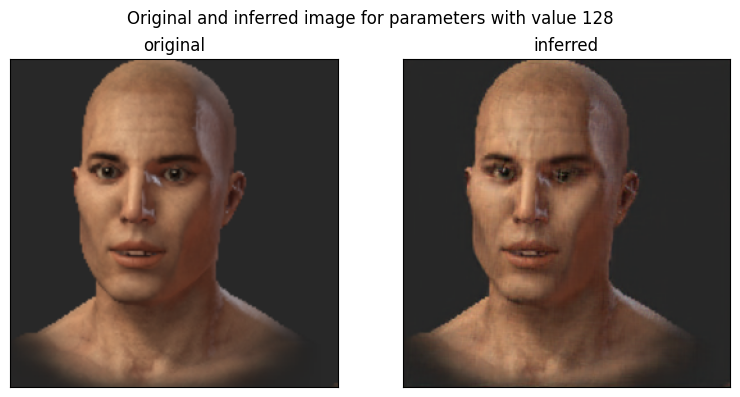

In [11]:
original_middle_image = prep_tensor_to_show(prep_image("img/from_dataset/middle_mercury.png"))
inffered_middle_image = prep_tensor_to_show(generator(middle_z)[0])

plot_images([original_middle_image, inffered_middle_image], ["original", "inferred"], nrows=1, ncols=2, title="Original and inferred image for parameters with value 128", figsize=[8, 4])


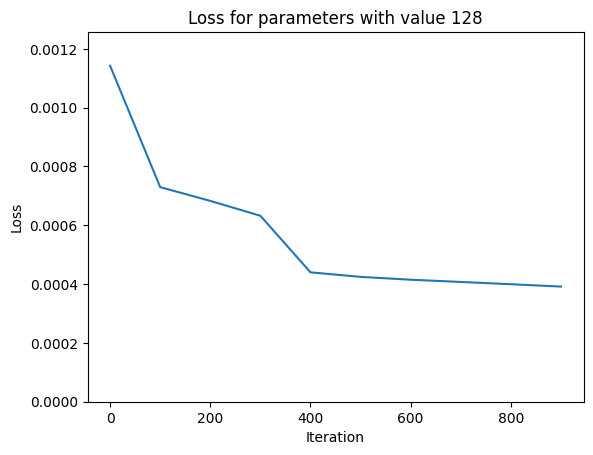

In [12]:
plot_loss(middle_losses, [i for i, _ in middle_checkpoints], title="Loss for parameters with value 128")

### Ingame freddie

In [13]:
ingame_freddie_z_fit = find_z_MSE(freddie_ingame, iterations=1000, lr=1, checkpoint_step=100)

Iteration: 0, loss: 2.71E-03
Iteration: 100, loss: 1.97E-03
Iteration: 200, loss: 1.95E-03
Iteration: 300, loss: 1.94E-03
Iteration: 400, loss: 1.93E-03
Iteration: 500, loss: 1.92E-03
Iteration: 600, loss: 1.92E-03
Iteration: 700, loss: 1.89E-03
Iteration: 800, loss: 1.88E-03
Iteration: 900, loss: 1.87E-03


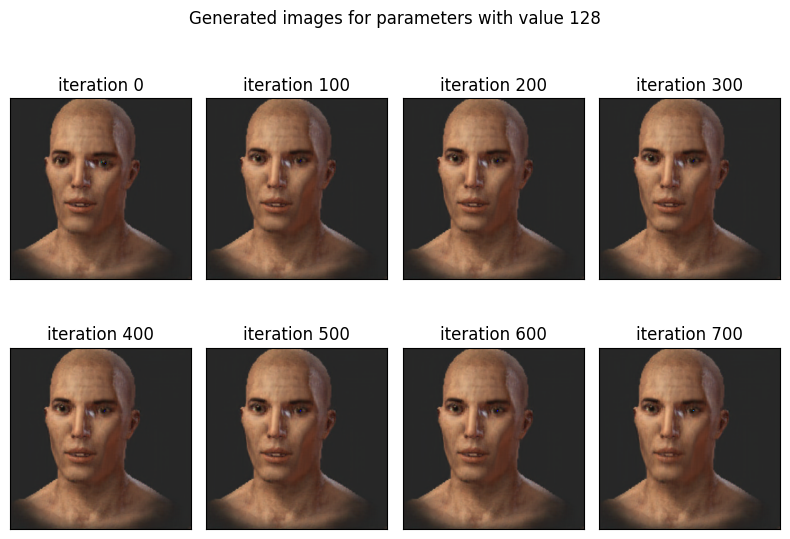

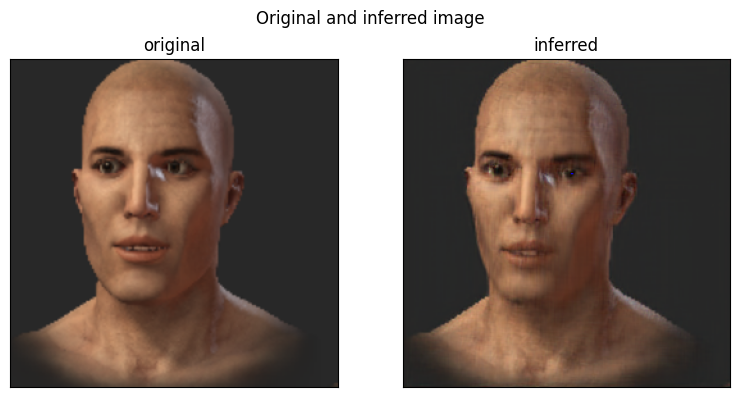

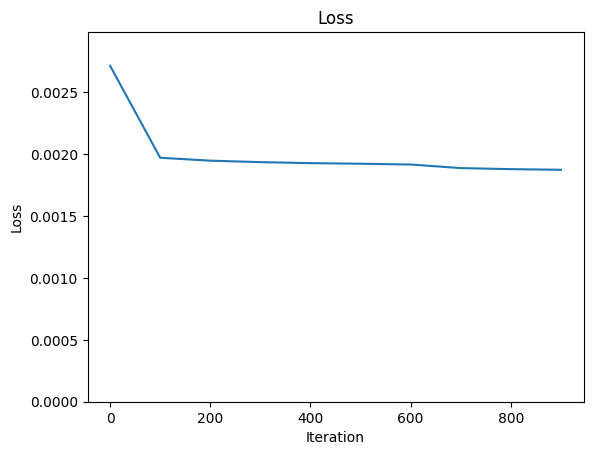

In [14]:
present_results(freddie_ingame, *ingame_freddie_z_fit)

### Real Freddie

In [15]:
real_freddie_z_fit = find_z_MSE(freddie_real, iterations=1000, lr=1, checkpoint_step=100)

Iteration: 0, loss: 2.58E-01
Iteration: 100, loss: 2.49E-01
Iteration: 200, loss: 2.42E-01
Iteration: 300, loss: 2.42E-01
Iteration: 400, loss: 2.42E-01
Iteration: 500, loss: 2.41E-01
Iteration: 600, loss: 2.41E-01
Iteration: 700, loss: 2.41E-01
Iteration: 800, loss: 2.41E-01
Iteration: 900, loss: 2.41E-01


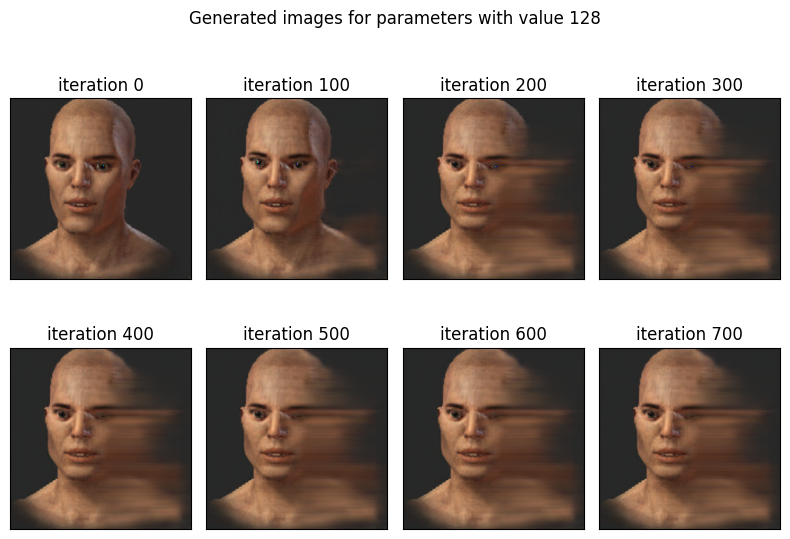

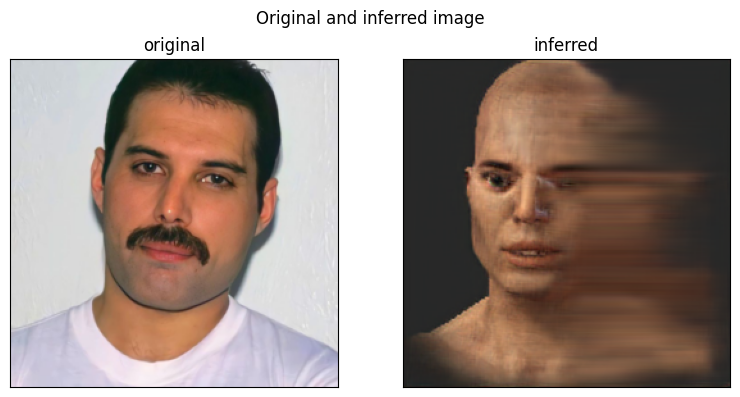

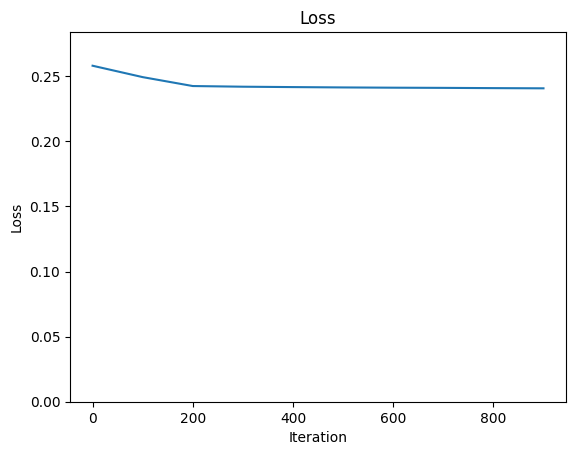

In [16]:
present_results(freddie_real, *real_freddie_z_fit)

## FaceNet512

Uzyskał zdecydowanie najlepsze wyniki w porównywaniu twarzy Freddiego z grą. Czy uda mu się znaleźć odpowiedni wektor z przestrzeni ukrytej?

### Czy on w ogóle wykrywa twarz z gry?

In [11]:
from deepface import DeepFace
from time import time


In [8]:
import tensorflow as tf

# Get the list of physical devices available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
 # Try to set the memory limit to 2GB (2048MB) on the first GPU
 try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
 except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-21 11:14:57.322401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 11:14:57.326347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 11:14:57.326961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

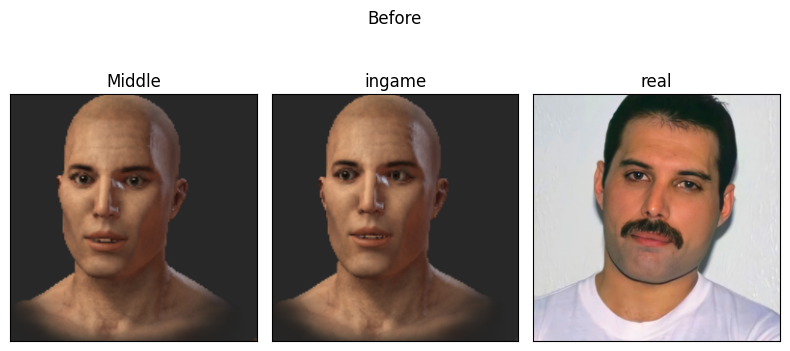

In [12]:
before = [prep_tensor_to_show(img) for img in [middle_image, freddie_ingame, freddie_real]]

plot_images(before, ["Middle", "ingame", "real"], 1, 3, title="Before")



2024-01-21 11:15:22.977340: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


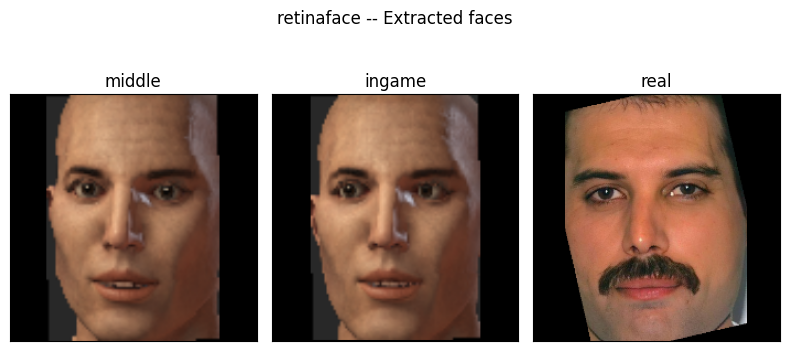

Time needed: 100.63280653953552 [s]
----------------------
1/1 [==============================] - 0s 39ms/step


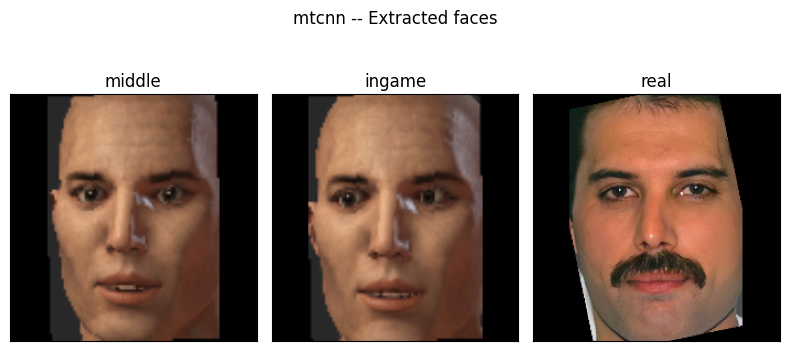

Time needed: 23.324480056762695 [s]
----------------------


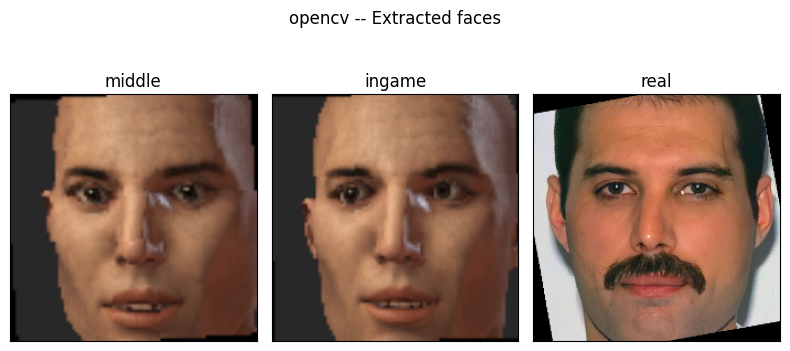

Time needed: 0.5427744388580322 [s]
----------------------


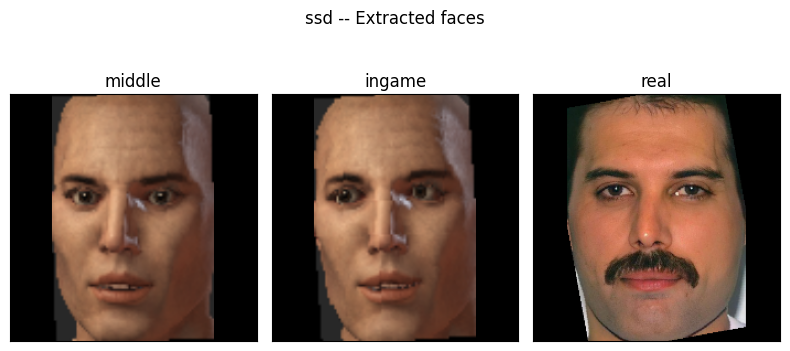

Time needed: 0.3878011703491211 [s]
----------------------
24-01-21 11:17:16 - shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


KeyError: 'content-type'

In [10]:

def extract_face(img_path: str, detector: str = "mtcnn") -> np.ndarray:
    extracted_face_dict = DeepFace.extract_faces(img_path=img_path, detector_backend=detector)
    if not extracted_face_dict:
        return np.zeros((224, 224))
    return extracted_face_dict[0]["face"]



for detector in ["retinaface", "mtcnn", "opencv", "ssd", "dlib"]:
    t1 = time()
    extracted_faces = [extract_face(img_path, detector=detector) for img_path in [MIDDLE_IMAGE_PATH, FREDDIE_INGAME_PATH, FREDDIE_REAL_PATH]]
    t2 = time()
    
    
    plot_images(extracted_faces, ["middle", "ingame", "real"], 1, 3, title=f"{detector} -- Extracted faces")
    print(f"Time needed: {t2 - t1} [s]")
    print("----------------------")
# plt.imshow(image)
# plt.show()

Imo RetinaFace najlepiej preprocesuje twarz (układa oczy na jednym poziomie)

### Using Deepface Facenet similarity as loss

In [13]:


im2vec_facenet512 = lambda img_path: DeepFace.represent(img_path=img_path, model_name="Facenet512", detector_backend="retinaface")
im2vec_facenet128 = lambda img_path: DeepFace.represent(img_path=img_path, model_name="Facenet", detector_backend="retinaface")

In [14]:

vectors = [im2vec_facenet128(img_path) for img_path in [MIDDLE_IMAGE_PATH, FREDDIE_INGAME_PATH, FREDDIE_REAL_PATH]]

In [15]:
def tensor2rgb(tensor):
    return (255*tensor.permute(1,2,0).detach().cpu().numpy()).astype(np.uint8)

def deepface2tensor(deepface_dict):
    return torch.tensor(deepface_dict["embedding"]).unsqueeze(0).cuda(0)

def tensor_img_embedding(img_tensor: torch.tensor) -> torch.tensor:
    return deepface2tensor(im2vec_facenet512(tensor2rgb(img_tensor))[0])

def euclid_dist(v1: torch.tensor, v2: torch.tensor) -> float:
    return torch.sqrt(torch.sum((v1 - v2)**2)).item()




In [16]:
vectors = [tensor_img_embedding(img) for img in [middle_image, freddie_ingame, freddie_real]]

for i, vector in enumerate(vectors):
    print(f"Vector {i}: {vector.shape}")
    
for v1, v2 in [(vectors[0], vectors[1]), (vectors[0], vectors[2]), (vectors[1], vectors[2])]:
    print(f"Euclidean distance between vectors: {euclid_dist(v1, v2)}")

Vector 0: torch.Size([1, 512])
Vector 1: torch.Size([1, 512])
Vector 2: torch.Size([1, 512])
Euclidean distance between vectors: 8.913723945617676
Euclidean distance between vectors: 25.105249404907227
Euclidean distance between vectors: 26.33768653869629


In [17]:
def find_z_Facenet512(exemplary_photo: str, iterations=100, lr=5, checkpoint_step=10, z_init=None):
    z = torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda") \
        if z_init is None else z_init
    y_target = tensor_img_embedding(exemplary_photo)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([z], lr=lr)

    checkpoints = []
    losses = []
    for i in range(iterations):
        img_pred = generator(z)[0]
        y_pred = tensor_img_embedding(img_pred)
        
        loss = criterion(y_target, y_pred)

        if i % checkpoint_step == 0:
            checkpoints.append((i, prep_tensor_to_show(img_pred)))
            losses.append(loss)
            print(f"Iteration: {i}, loss: {loss.item():.2E}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return z, checkpoints, losses

In [18]:
middle_z = find_z_Facenet512(middle_image, iterations=1000, lr=1, checkpoint_step=100)

Iteration: 0, loss: 2.83E-01


TypeError: Tensor.backward() got an unexpected keyword argument 'require_grad'

CUDA out of memory ... It is possible that Keras takes GPU from PyTorch.

### Facenet from timesler Facenet PyTorch



In [11]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [12]:
mtcnn = MTCNN(device="cuda", image_size=IMG_SIZE)
facenet = InceptionResnetV1(pretrained='vggface2').eval().cuda()

In [13]:
def tensor2pillow(tensor):
    return v2.ToPILImage()(tensor.detach().cpu().squeeze())

def embed_pytorch_facenet(img_tensor: torch.tensor) -> torch.tensor:
    pil_image = tensor2pillow(img_tensor)
    cropped = mtcnn(pil_image, ).unsqueeze(0).cuda(0)
    return facenet(cropped)[0]

def euclid_dist(v1: torch.tensor, v2: torch.tensor) -> float:
    return torch.sqrt(torch.sum((v1 - v2)**2)).item()


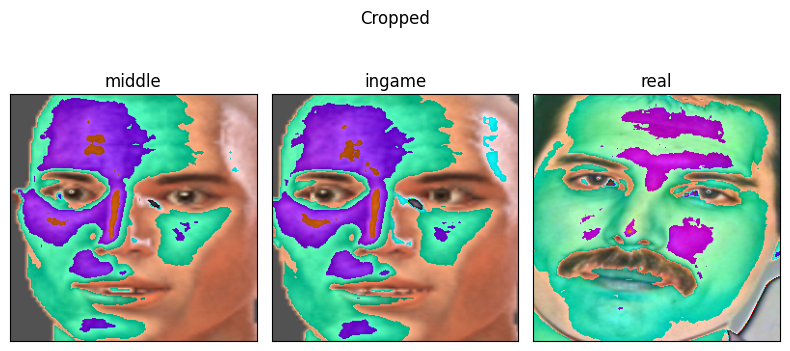

In [14]:


cropped = [mtcnn((tensor2pillow(img))) for img in [middle_image, freddie_ingame, freddie_real]]



plot_images([prep_tensor_to_show(img) for img in cropped], ["middle", "ingame", "real"], 1, 3, title="Cropped")

For some unknown reason the faces are skewed... Well, we will fix that later.

On top of that - I have no idea what do those strange marks on the face mean. Something between activation maps and a Remain in Light reference.

In [15]:
facenet(cropped[0].unsqueeze(0).cuda(0)).shape

torch.Size([1, 512])

In [16]:
vectors = [embed_pytorch_facenet(img) for img in [middle_image, freddie_ingame, freddie_real]]


In [17]:
for vec1, vec2 in [(vectors[0], vectors[1]), (vectors[0], vectors[2]), (vectors[1], vectors[2])]:
    print(f"Euclidean distance between vectors: {euclid_dist(vec1, vec2)}")
    
    

Euclidean distance between vectors: 0.3016345500946045
Euclidean distance between vectors: 0.9051283001899719
Euclidean distance between vectors: 0.9523900151252747


In [20]:
def find_z_pytorch_facenet(exemplary_photo: torch.tensor, iterations=100, lr=0.001, checkpoint_step=10, z_init=None):
    z = torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda") \
        if z_init is None else z_init
    y_target = embed_pytorch_facenet(exemplary_photo).detach()
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([z], lr=lr)

    checkpoints = []
    losses = []
    for i in range(iterations):
        img_pred = generator(z)[0]
        y_pred = embed_pytorch_facenet(img_pred)
        
        loss = criterion(y_target, y_pred)

        if i % checkpoint_step == 0:
            checkpoints.append((i, prep_tensor_to_show(img_pred)))
            losses.append(loss.item())
            print(f"Iteration: {i}, loss: {loss.item():.2E}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return z, checkpoints, losses

In [21]:
middle_z_facenet, middle_checkpoints_facenet, middle_losses_facenet = find_z_pytorch_facenet(middle_image, iterations=5000, checkpoint_step=100)

Iteration: 0, loss: 5.15E-04
Iteration: 100, loss: 5.14E-04
Iteration: 200, loss: 5.17E-04
Iteration: 300, loss: 5.13E-04
Iteration: 400, loss: 5.15E-04
Iteration: 500, loss: 4.85E-04
Iteration: 600, loss: 4.85E-04
Iteration: 700, loss: 5.17E-04
Iteration: 800, loss: 5.15E-04
Iteration: 900, loss: 5.17E-04
Iteration: 1000, loss: 4.85E-04
Iteration: 1100, loss: 5.17E-04
Iteration: 1200, loss: 5.17E-04
Iteration: 1300, loss: 5.17E-04
Iteration: 1400, loss: 5.13E-04
Iteration: 1500, loss: 5.19E-04
Iteration: 1600, loss: 5.17E-04
Iteration: 1700, loss: 5.16E-04
Iteration: 1800, loss: 4.87E-04
Iteration: 1900, loss: 5.19E-04
Iteration: 2000, loss: 5.19E-04
Iteration: 2100, loss: 5.16E-04
Iteration: 2200, loss: 5.16E-04
Iteration: 2300, loss: 5.11E-04
Iteration: 2400, loss: 5.15E-04
Iteration: 2500, loss: 5.13E-04
Iteration: 2600, loss: 5.14E-04
Iteration: 2700, loss: 5.20E-04
Iteration: 2800, loss: 5.17E-04
Iteration: 2900, loss: 5.18E-04
Iteration: 3000, loss: 5.15E-04
Iteration: 3100, los

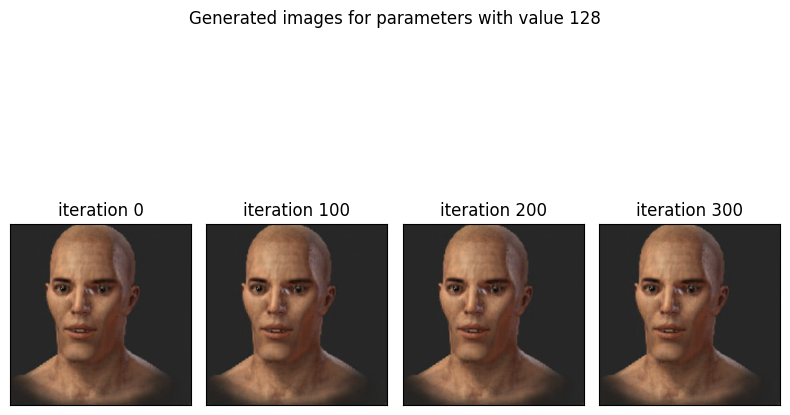

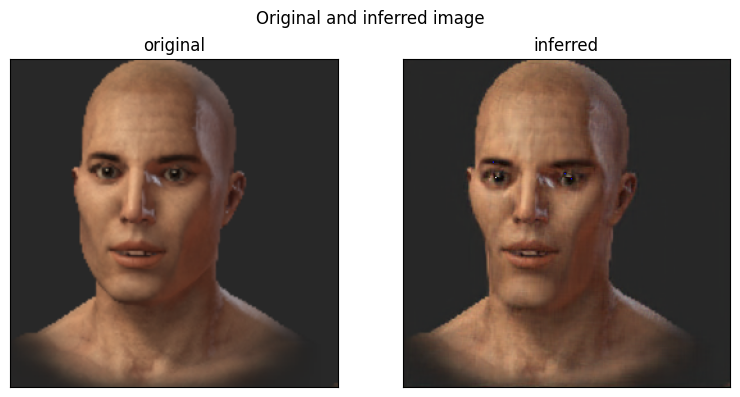

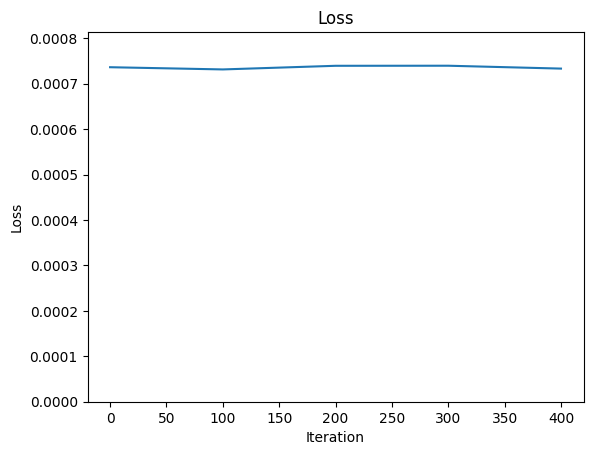

In [ ]:
present_results(middle_image, middle_z_facenet, middle_checkpoints_facenet, middle_losses_facenet)


Iteration: 0, loss: 7.80E-04
Iteration: 100, loss: 7.85E-04
Iteration: 200, loss: 7.83E-04
Iteration: 300, loss: 7.85E-04
Iteration: 400, loss: 7.85E-04
Iteration: 500, loss: 7.84E-04
Iteration: 600, loss: 7.80E-04
Iteration: 700, loss: 7.83E-04
Iteration: 800, loss: 7.80E-04
Iteration: 900, loss: 7.84E-04
Iteration: 1000, loss: 7.81E-04
Iteration: 1100, loss: 7.82E-04
Iteration: 1200, loss: 7.86E-04
Iteration: 1300, loss: 7.80E-04
Iteration: 1400, loss: 7.80E-04
Iteration: 1500, loss: 7.79E-04
Iteration: 1600, loss: 7.80E-04
Iteration: 1700, loss: 7.80E-04
Iteration: 1800, loss: 8.23E-04
Iteration: 1900, loss: 7.78E-04
Iteration: 2000, loss: 7.81E-04
Iteration: 2100, loss: 7.79E-04
Iteration: 2200, loss: 7.81E-04
Iteration: 2300, loss: 7.80E-04
Iteration: 2400, loss: 7.80E-04
Iteration: 2500, loss: 7.84E-04
Iteration: 2600, loss: 7.83E-04
Iteration: 2700, loss: 7.84E-04
Iteration: 2800, loss: 7.79E-04
Iteration: 2900, loss: 7.82E-04
Iteration: 3000, loss: 7.81E-04
Iteration: 3100, los

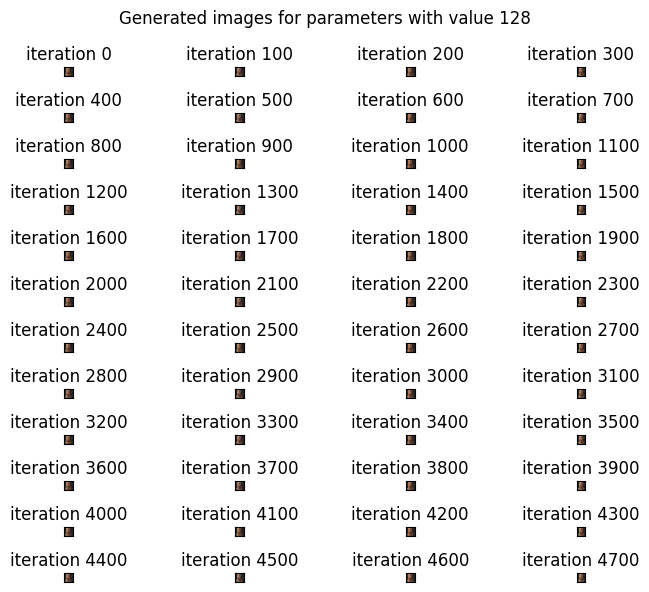

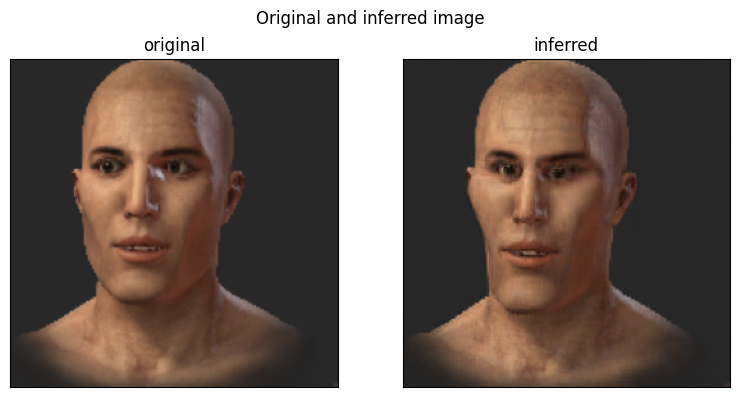

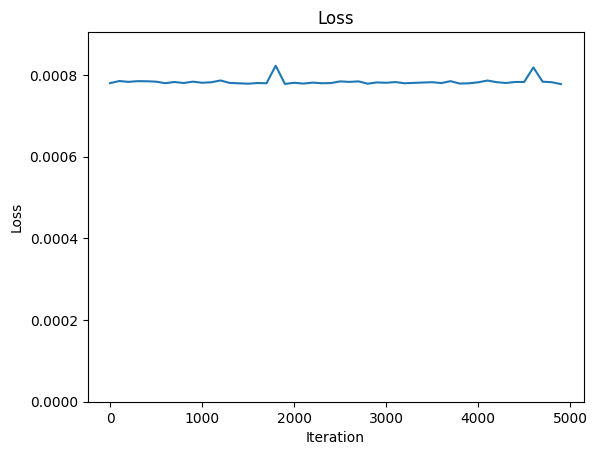

In [22]:
facenet_ingame_z = find_z_pytorch_facenet(freddie_ingame, iterations=5000, checkpoint_step=100)
present_results(freddie_ingame, *facenet_ingame_z)

Iteration: 0, loss: 2.26E-03
Iteration: 100, loss: 2.26E-03
Iteration: 200, loss: 2.26E-03
Iteration: 300, loss: 2.26E-03
Iteration: 400, loss: 2.26E-03
Iteration: 500, loss: 2.26E-03
Iteration: 600, loss: 2.26E-03
Iteration: 700, loss: 2.26E-03
Iteration: 800, loss: 2.26E-03
Iteration: 900, loss: 2.27E-03
Iteration: 1000, loss: 2.26E-03
Iteration: 1100, loss: 2.26E-03
Iteration: 1200, loss: 2.27E-03
Iteration: 1300, loss: 2.26E-03
Iteration: 1400, loss: 2.26E-03
Iteration: 1500, loss: 2.26E-03
Iteration: 1600, loss: 2.27E-03
Iteration: 1700, loss: 2.26E-03
Iteration: 1800, loss: 2.27E-03
Iteration: 1900, loss: 2.26E-03
Iteration: 2000, loss: 2.26E-03
Iteration: 2100, loss: 2.26E-03
Iteration: 2200, loss: 2.26E-03
Iteration: 2300, loss: 2.26E-03
Iteration: 2400, loss: 2.26E-03
Iteration: 2500, loss: 2.26E-03
Iteration: 2600, loss: 2.26E-03
Iteration: 2700, loss: 2.27E-03
Iteration: 2800, loss: 2.27E-03
Iteration: 2900, loss: 2.26E-03
Iteration: 3000, loss: 2.26E-03
Iteration: 3100, los

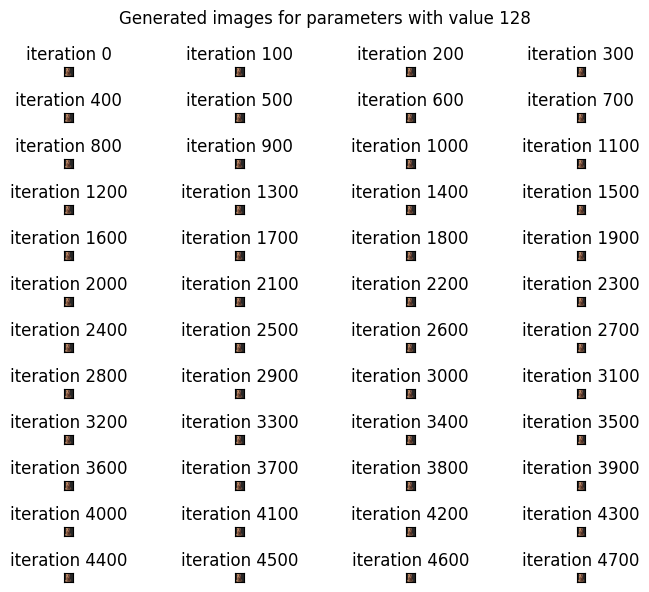

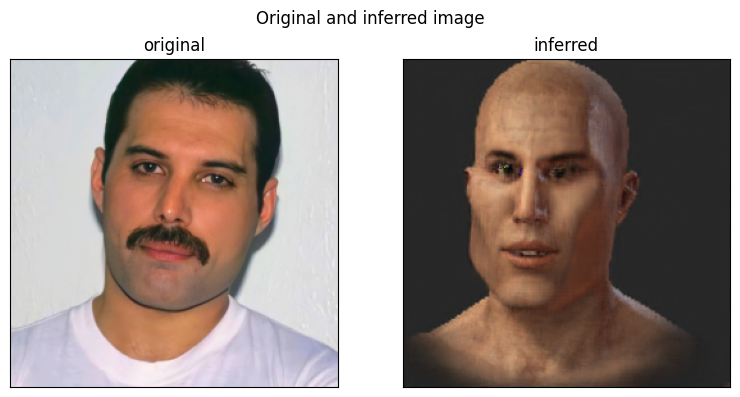

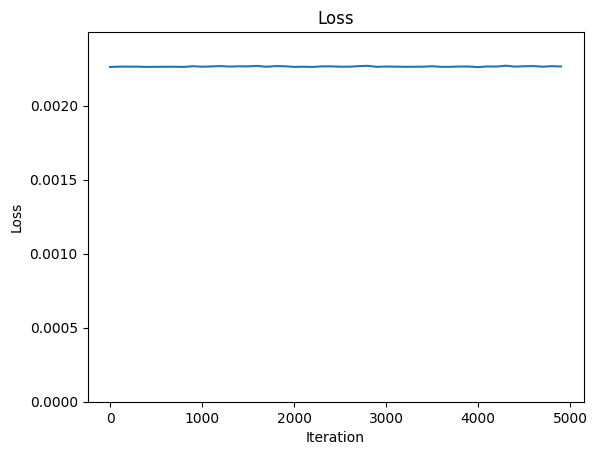

In [23]:
facenet_real_z = find_z_pytorch_facenet(freddie_real, iterations=5000, checkpoint_step=100)
present_results(freddie_real, *facenet_real_z)

### RetinaFace Alignment + Facial Landmarks

In [10]:
from insightface.app import FaceAnalysis
from insightface.data

app = FaceAnalysis(allowed_modules=["detection", "landmark_2d_106"], device="cuda")
app.prepare(ctx_id=0, det_size=(IMG_SIZE, IMG_SIZE))

app.get(img=)

ModuleNotFoundError: No module named 'insigtface'